In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Data Science Project - Spring 2021

[Microprediction LLC](https://www.microprediction.com/)  is established to foster development of the world's first microprediction network and its use by organizations large and small.
They have built a network of real-time data and algorithms to make low-cost, high-quality predictions accessible and useful.
Getting predictions is as simple as publishing data to their platform where competing, state-of-the art algorithms converge on optimized predictions.

![image](microprediction.png)

**Project description:** In this project, the students would learn how to write and deploy programs that directly address real-time operational problems. 
These would predict quantities such as electricity  or cryptocurrency movements.
Students would also be able to create intelligent applications, such as a web page, that uses the turnkey prediction API to drive intelligence, thus pioneering new ways to exploit cheap prediction.

**Table of contents**:

- [The NYISO streams](#The-NYISO-streams)
- [Daily average electricity production based on weather](#Daily-average-electricity-production-based-on-weather)
- [A Random Forest model that predicts daily average electricity](#A-Random-Forest-model-that-predicts-daily-average-electricity)
- [Daily electricity curves: whales, camels and elephants](#Daily-electricity-curves)
- [Clustering daily electricity curves](#Clustering-daily-electricity-curves)
- [A Random Forest model that predicts the shape of the daily electricity curve](#A-Random-Forest-model-that-predicts-the-shape-of-the-daily-electricity-curve)
- [Parameterizing daily electricity curves](#Parameterizing-daily-electricity-curves)
- [Putting it all together: forecasting electricity daily curves](#Putting-it-all-together:-forecasting-electricity-daily-curves)

## The NYISO streams

The students decidided to focus on the prediction of the [NYISO](https://www.nyiso.com/) streams (New York City electricity production).

NYISO divides NYC into 11 zones: WEST, GENESE, CENTRL, NORTH, MHK VL, CAPITL, HUD VL, MILLWD, DUNWOD, N.Y.C., LONGIL. Each student was assigned two of these zones.

![image](nyc_zones.png)

In this notebook, we present the results for the CAPITL zone.

To train the Machine Learning prediction models, the students obtained historical data from the NYISO website.

![image](nyiso.png)

In [2]:
# load 2020-2021 electricity production data (CAPITL zone)
load = pd.read_csv('data\load_CAPITL.csv', index_col='RTD End Time Stamp', parse_dates =True)[['RTD Actual Load']].resample('5min').mean()
load.index.name = 'Date'
load.columns = ['Load']
load.head()

,Load
Date,
2020-01-01 00:05:00,1191.0
2020-01-01 00:10:00,1195.5
2020-01-01 00:15:00,1210.9
2020-01-01 00:20:00,1186.3
2020-01-01 00:25:00,1189.1


Text(0, 0.5, 'Watts')

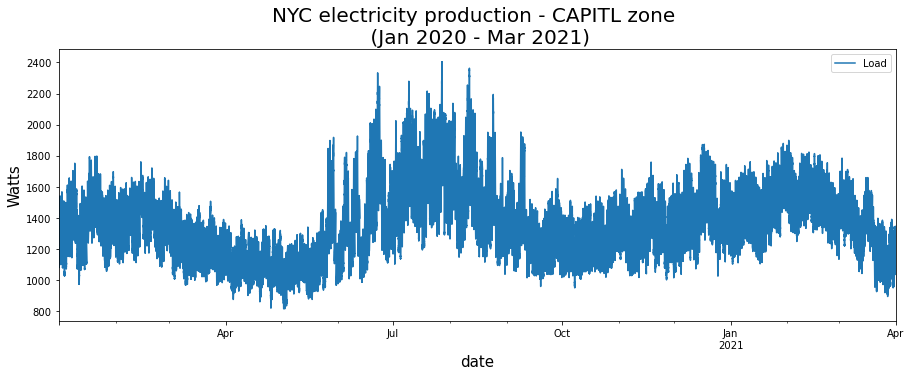

In [3]:
fig, ax = plt.subplots(figsize=(15,5))
load.plot(ax=ax)
ax.set_title('NYC electricity production - CAPITL zone \n (Jan 2020 - Mar 2021)', fontsize=20)
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('Watts', fontsize=15)

Text(0, 0.5, 'Watts')

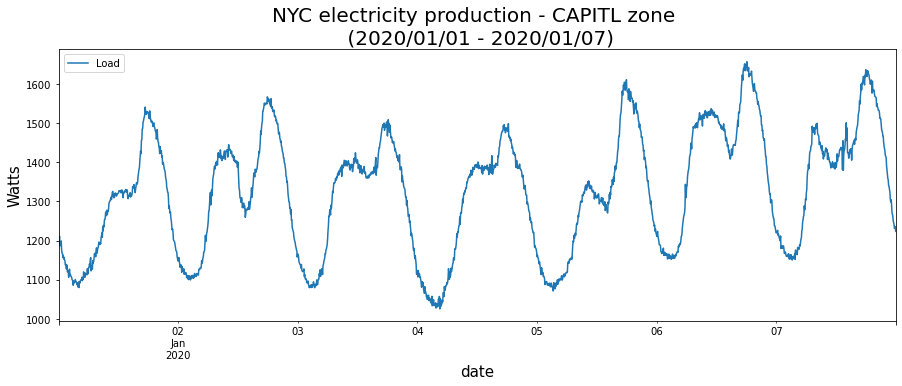

In [4]:
# zoom in
fig, ax = plt.subplots(figsize=(15,5))
load['2020-01-01':'2020-01-07'].plot(ax=ax)
ax.set_title('NYC electricity production - CAPITL zone \n (2020/01/01 - 2020/01/07)', fontsize=20)
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('Watts', fontsize=15)

## Daily average electricity production based on weather

Our first task was to predict the **average daily electricity production**.

In [6]:
# compute average daily electricity production
daily_load = load.resample('d').mean()

Text(0, 0.5, 'Watts')

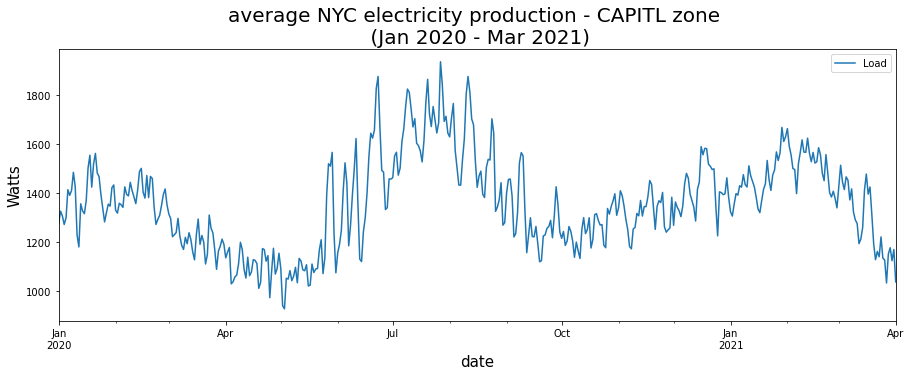

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
daily_load.plot(ax=ax)
ax.set_title('average NYC electricity production - CAPITL zone \n (Jan 2020 - Mar 2021)', fontsize=20)
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('Watts', fontsize=15)

Our prediction models used the following features to predict the average daily electricity:
    
- **Weather features**
    - daily max temperature
    - wind speed
    - precipitation
- **Date features**
    - day of the week (Sun, Mon, Tue, ect)
    - month of the year (Jan, Feb, Mar, ect)
    - whether the day is a holiday or not
- **Data stream features**
    - First daily data point
    - average daily electricity from 1, 2 and 3 days before.


We obtained historical weather data from [NOAA climate data portal](https://www.ncdc.noaa.gov/cdo-web/)

![image](noaa.png)

In [8]:
# load weather data
weather = pd.read_csv('weather\weather_nyc_daily_2015-2021.csv',index_col='DATE',parse_dates=True)
# filter dates
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('2021-03-31')
weather = weather[start:end]
weather.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",17.67,NaN,0.00,0.0,0.0,40,42,34,...,28.0,38.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",9.62,NaN,0.00,0.0,0.0,38,48,31,...,16.1,21.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",6.49,NaN,0.13,0.0,0.0,44,48,42,...,13.0,16.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",8.28,NaN,0.16,0.0,0.0,47,51,43,...,25.9,35.1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",21.47,NaN,0.00,0.0,0.0,41,49,35,...,38.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
'prepare data used to train the model'

data_load = pd.DataFrame(index=daily_load.index)
# electricity load
data_load['load'] = daily_load['Load'] 

# MAX temperature
data_load['temp'] = weather['TMAX'] 

# wind speed
data_load['wind speed'] = weather['AWND'] 

# precipitation
data_load['precipitation'] = weather['PRCP'] 

# holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
holidays = USFederalHolidayCalendar().holidays('2020-01-01','2021-03-31')
data_load = data_load.join(pd.Series(1, index=holidays,name='holiday'))
data_load['holiday'].fillna(0, inplace=True)

# day of the week
data_load['day_of_week'] = data_load.index.dayofweek

# month
data_load['month'] = data_load.index.month

# first data point of the day
first_load = load.groupby(load.index.date).head(1)
first_load.index = first_load.index.date
data_load['first'] = first_load

# previous load (skip this cell)
data_load['load-1d'] = data_load.load.shift(1)
data_load['load-2d'] = data_load.load.shift(2)
data_load['load-3d'] = data_load.load.shift(3)

# drop rows with missing values
data_load.dropna(axis=0, inplace=True)

# display top 10 rows 
data_load.head(10)

,load,temp,wind speed,precipitation,holiday,day_of_week,month,first,load-1d,load-2d,load-3d
Date,,,,,,,,,,,
2020-01-04,1271.805903,51.0,8.28,0.16,0.0,5,1,1123.3,1306.837384,1325.960069,1275.686063
2020-01-05,1299.112211,49.0,21.47,0.00,0.0,6,1,1159.0,1271.805903,1306.837384,1325.960069
2020-01-06,1413.612037,45.0,13.87,0.03,0.0,0,1,1210.9,1299.112211,1271.805903,1306.837384
2020-01-07,1390.814931,44.0,8.50,0.03,0.0,1,1,1219.3,1413.612037,1299.112211,1271.805903
2020-01-08,1410.498438,43.0,20.80,0.00,0.0,2,1,1224.5,1390.814931,1413.612037,1299.112211
2020-01-09,1484.531707,34.0,11.18,0.00,0.0,3,1,1324.2,1410.498438,1390.814931,1413.612037
2020-01-10,1426.346528,51.0,7.83,0.00,0.0,4,1,1320.9,1484.531707,1410.498438,1390.814931
2020-01-11,1229.251042,57.0,17.90,0.00,0.0,5,1,1178.4,1426.346528,1484.531707,1410.498438
2020-01-12,1180.278472,68.0,19.91,0.03,0.0,6,1,1061.4,1229.251042,1426.346528,1484.531707


We tried several ML regression models.
Random Forest performed best.

## A Random Forest model that predicts daily average electricity 

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [11]:
# feature matrix # 'wind speed','precipitation',
X = data_load.drop('load',axis=1)
# target vector
y = data_load.load

In [12]:
'build a Machile Learning regression pipeline'

# numeric processor
numeric_features = ['temp','first','wind speed','precipitation','load-1d','load-2d','load-3d','holiday']
numeric_processor = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# categorical processor
categorical_features = ['day_of_week','month']
categorical_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_processor, numeric_features),
        ('cat', categorical_processor, categorical_features)])

# pipeline
pipe = Pipeline(steps=[
    ('processor', feature_processor),
    ('reg', RandomForestRegressor(n_jobs=-1))
])

In [13]:
# grid search to tune-in model hyperparameters

param_grid = { 
    'reg__n_estimators': [50, 100, 200], # The number of trees in the forest
    'reg__max_depth' : [2,5,10,20,50], # The maximum depth of the tree
    'reg__min_samples_split' : [2,4,8,16], # The minimum number of samples required to split an internal node
    'reg__min_samples_leaf' : [1,2,4,8,16], # The minimum number of samples required to be at a leaf node
}
grid = GridSearchCV(pipe, 
                    param_grid, 
                    cv=5, 
                    scoring='neg_root_mean_squared_error', 
                    verbose=True, 
                    n_jobs=-1)
grid.fit(X, y) 

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'first',
                                                                          'wind '
                                                                          'speed',
                                                                          'precipitation',
                                                                          'load-1d',
                                                                          'load-2d',
                                              

In [14]:
# display best model hyperparameters
grid.best_params_

{'reg__max_depth': 20,
 'reg__min_samples_leaf': 1,
 'reg__min_samples_split': 4,
 'reg__n_estimators': 100}

In [15]:
# best predictor
forest_load_clf = grid.best_estimator_

Text(0.5, 1.0, 'average NYC electricity production - CAPITL zone \n (Jan 2020 - Mar 2021)')

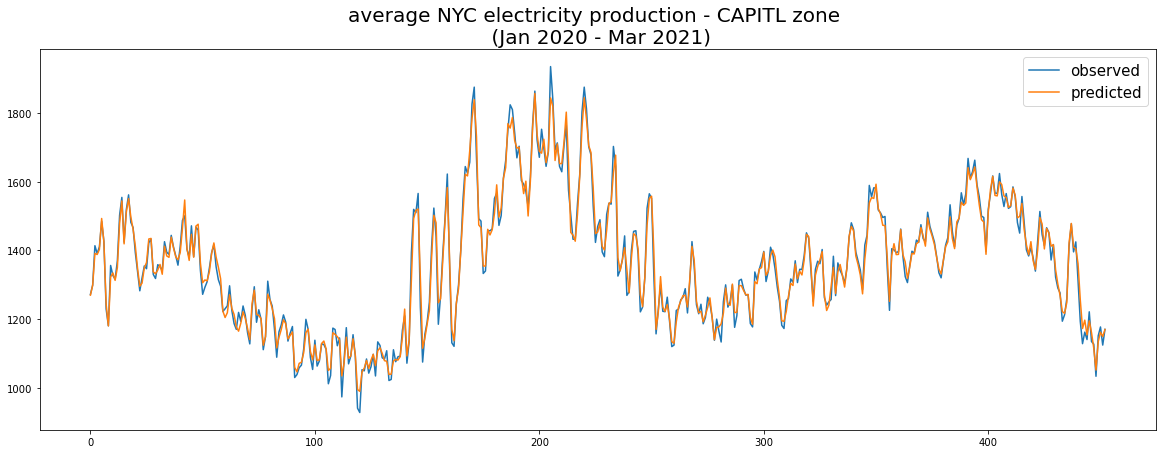

In [17]:
# fit and predict
forest_load_clf.fit(X,y)
y_pred = forest_load_clf.predict(X)

# plot predictions
plt.figure(figsize=(20,7))
plt.plot(y.to_numpy(), label ='observed')
plt.plot(y_pred, label= 'predicted')
plt.legend(fontsize=15)
plt.title('average NYC electricity production - CAPITL zone \n (Jan 2020 - Mar 2021)', fontsize=20)

Text(0.5, 1.0, 'average daily electricity production \n observed vs predicted')

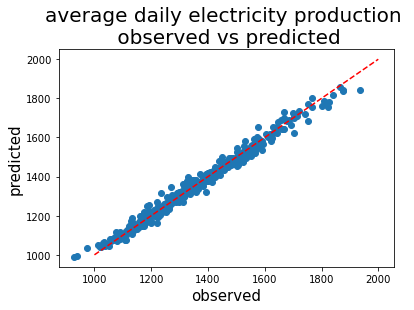

In [23]:
# observed vs predicted
plt.scatter(y,y_pred)
plt.xlabel('observed', fontsize=15)
plt.ylabel('predicted', fontsize=15)
plt.plot([1000,2000],[1000,2000],'r--')
plt.title('average daily electricity production \n observed vs predicted', fontsize=20)

All the model predictions are very accurate!

In [ ]:
# save model
import pickle

pkl_filename = "forest_load_CAPITL.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(forest_load_clf, file)

## Daily electricity curves

The next task was to predict the **shape of the daily electricity curves**.

Text(0, 0.5, 'Watts')

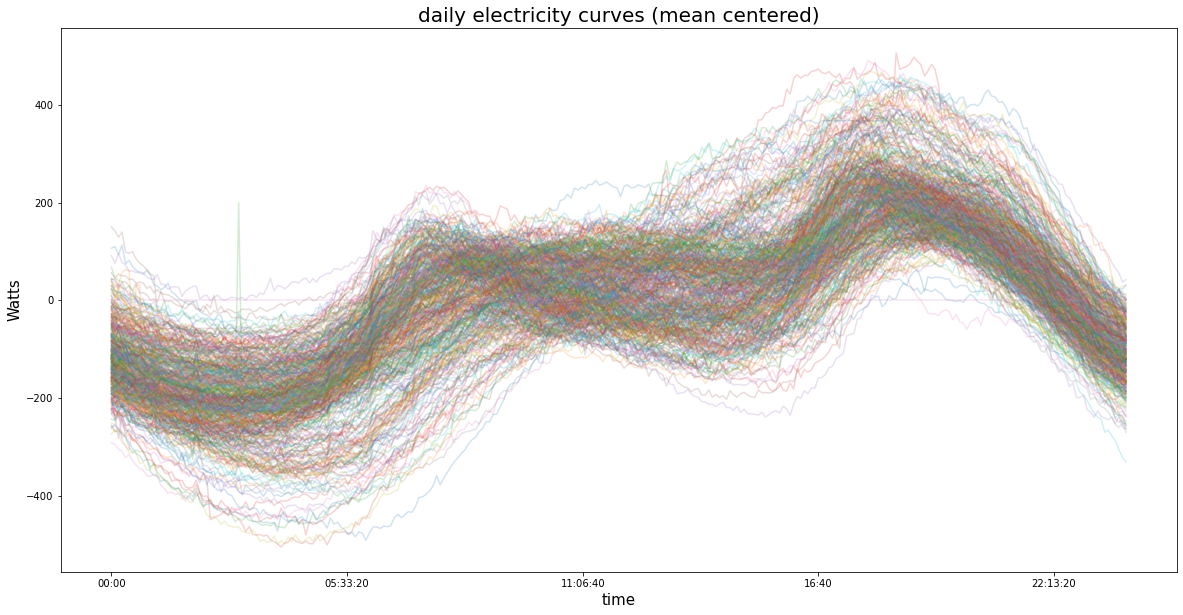

In [203]:
data_table = pd.pivot_table(data = load, values = 'Load', index = load.index.time, columns = load.index.date)
# subtract the mean 
data_table_centered = data_table - data_table.mean()
# fill missing values
data_table_centered = data_table_centered.fillna(method='backfill',axis=0)
data_table_centered = data_table_centered.fillna(method='ffill',axis=0)
# plot daily curves
data_table_centered.plot(legend=False,alpha=0.2, figsize=(20,10))
plt.title('daily electricity curves (mean centered)', fontsize=20)
plt.xlabel('time', fontsize=15)
plt.ylabel('Watts', fontsize=15)

The students noticed that there are three general shapes: "the whale", "the camel" and "the elephant"

<AxesSubplot:title={'center':'the whale (2020-05-26)'}, xlabel='time'>

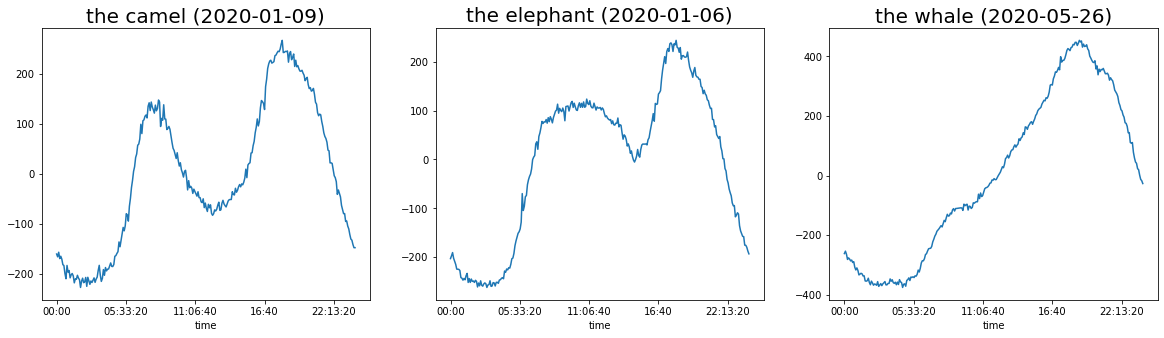

In [204]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].set_title('the camel (2020-01-09)', fontsize=20)
data_table_centered.iloc[:,8].plot(ax=ax[0])

ax[1].set_title('the elephant (2020-01-06)', fontsize=20)
data_table_centered.iloc[:,5].plot(ax=ax[1])

ax[2].set_title('the whale (2020-05-26)', fontsize=20)
data_table_centered.iloc[:,146].plot(ax=ax[2])

A natural question is: *can we predict the shape of the curve based on weather/date data?*

## Clustering daily electricity curves

To automaticaly label the daily curves as shape 0, 1 or 2 (whales, camels, or elephants), the students did some cluster analysis.

In [286]:
from sklearn.cluster import KMeans

In [287]:
# transpose the data so that each row corresponds to a day
data = data_table_centered.T

In [288]:
#kmeans clustering
k = 3
cluster = KMeans(n_clusters=k)
cluster.fit(data)

# cluster labels and centers
centers = cluster.cluster_centers_
labels = cluster.labels_

# put cluster centers into a dataframe
cluster_small = pd.DataFrame(centers.T, index=data_table.index)

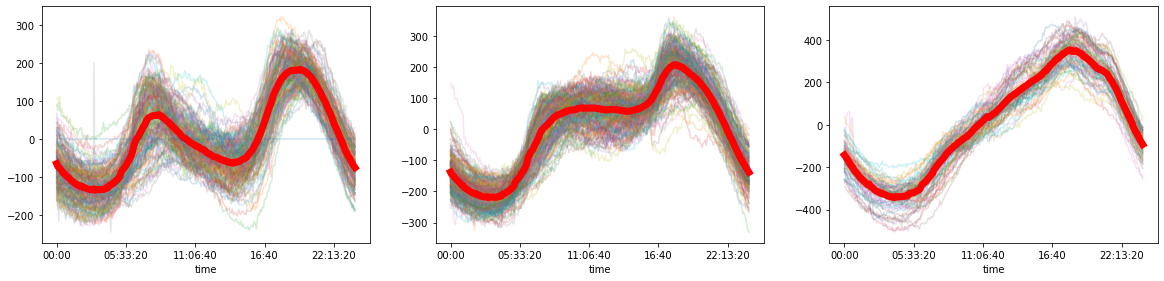

In [289]:
# plot cluster centers + clusters
plt.figure(figsize=(20,20))
for i in range(k):
    plt.subplot(4,3,i+1)
    ax = plt.gca()
    data_table_centered.iloc[:,labels==i].plot(ax=ax, legend=False,alpha=0.2)
    cluster_small[i].plot(ax = ax, color='red', linewidth=7)    

It looks like that the clusters really correspond the the three shapes the students noticed.

## A Random Forest model that predicts the shape of the daily electricity curve

We trained a Random Forest model that predicts the shape of the daily electricity curves (whales, camels, elephants)

In [290]:
cluster_data = pd.DataFrame(labels,columns=['cluster'], index=data.index)
cluster_data.index.name = 'DATE'
cluster_data.index = pd.to_datetime(cluster_data.index)

# day of the week and month columns:
cluster_data['month'] = cluster_data.index.month
cluster_data['day_of_week'] = cluster_data.index.dayofweek

# holiday 
from pandas.tseries.holiday import USFederalHolidayCalendar
holidays = USFederalHolidayCalendar().holidays('2020-01-01','2021-03-31')
cluster_data = cluster_data.join(pd.Series(1, index=holidays,name='holiday'))
cluster_data['holiday'].fillna(0, inplace=True)

# MAX temperature
cluster_data['temp'] = weather['TMAX'] 

# wind speed
cluster_data['wind speed'] = weather['AWND'] 

# precipitation
cluster_data['precipitation'] = weather['PRCP'] 

# first data point of the day
first_load = load.groupby(load.index.date).head(1)
first_load.index = first_load.index.date
cluster_data['first'] = first_load

# previous cluster
cluster_data['cluster-1d'] = cluster_data.cluster.shift(1)

# drop rows with missing values
cluster_data.dropna(axis=0,inplace=True)

cluster_data.head()

,cluster,month,day_of_week,holiday,temp,wind speed,precipitation,first,cluster-1d
DATE,,,,,,,,,
2020-01-02,1,1,3,0.0,48.0,9.62,0.00,1148.0,1.0
2020-01-03,1,1,4,0.0,48.0,6.49,0.13,1166.3,1.0
2020-01-04,1,1,5,0.0,51.0,8.28,0.16,1123.3,1.0
2020-01-05,1,1,6,0.0,49.0,21.47,0.00,1159.0,1.0
2020-01-06,1,1,0,0.0,45.0,13.87,0.03,1210.9,1.0


In [291]:
# Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# feature matrix/target vector
y = cluster_data.cluster
X = cluster_data.drop('cluster',axis=1)

In [292]:
'build a Machile Learning classification pipeline'

# numeric processor
numeric_features = ['temp','first','wind speed','precipitation','cluster-1d','holiday']
numeric_processor = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# categorical processor
categorical_features = ['day_of_week','month']
categorical_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# column transformer
feature_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_processor, numeric_features),
        ('cat', categorical_processor, categorical_features)])

# pipeline
pipe = Pipeline(steps=[
    ('processor', feature_processor),
    ('reg', RandomForestClassifier(n_jobs=-1))
])

In [293]:
# grid search to tune-in model hyperparameters

param_grid = { 
    'reg__n_estimators': [10, 25, 50, 100, 200], # The number of trees in the forest
    'reg__max_depth' : [10,20,50,100], # The maximum depth of the tree
    'reg__min_samples_split' : [2,4,8,16,32], # The minimum number of samples required to split an internal node
    'reg__min_samples_leaf' : [1,2,4,8,16,32], # The minimum number of samples required to be at a leaf node
}
grid = GridSearchCV(pipe, 
                    param_grid, 
                    cv=5, 
                    scoring='accuracy', 
                    verbose=True, 
                    n_jobs=-1)
grid.fit(X, y) 

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'first',
                                                                          'wind '
                                                                          'speed',
                                                                          'precipitation',
                                                                          'cluster-1d',
                                                                          'holiday']),
                                         

In [294]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.7120879120879121
{'reg__max_depth': 10, 'reg__min_samples_leaf': 16, 'reg__min_samples_split': 8, 'reg__n_estimators': 25}


In [295]:
# predictions
forest_cluster_clf = grid.best_estimator_
y_pred = forest_cluster_clf.predict(X)

In [296]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y, y_pred)

array([[111,  46,   3],
       [ 23, 188,  14],
       [  3,   6,  61]], dtype=int64)

70% of accuracy. 
Not great, not terrible.

In [297]:
# save classification model
import pickle

pkl_filename = "forest_cluster_CAPITL.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(forest_clf, file)

## Parameterizing daily electricity curves

Next, the students tried to find a way to describe accurately all the daily electricity curves. 
They tried many families of curves.
At the end, the students found that describing electricity curves as linear combinations of 10 cluster centers worked best.

Text(0.5, 1.0, 'cluster centers')

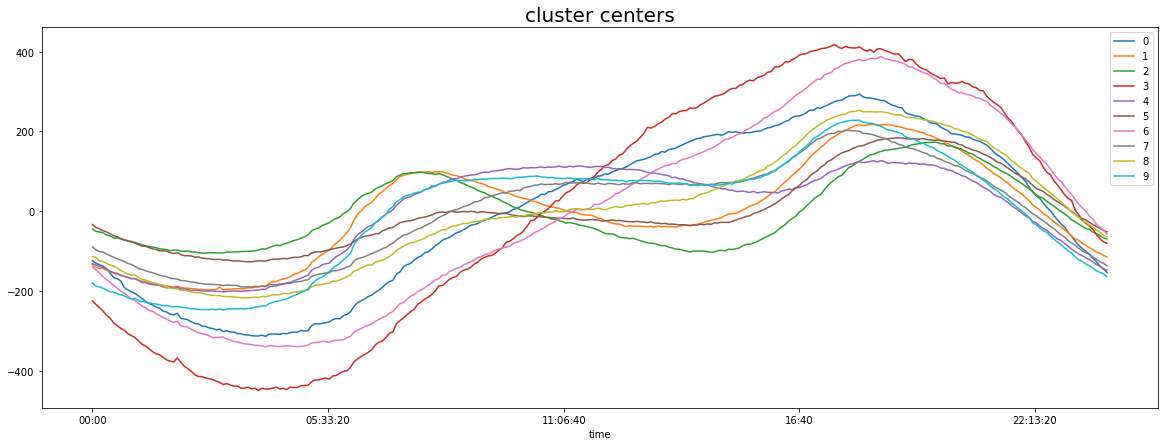

In [223]:
k = 10
cluster = KMeans(n_clusters=k)
cluster.fit(data)

# cluster labels and centers
centers = cluster.cluster_centers_
labels = cluster.labels_

# put cluster centers into a dataframe
cluster_centers = pd.DataFrame(centers.T, index=data_table.index)

# plot cluster centers
fig, ax = plt.subplots(figsize=(20,7))
for i in range(k):
    cluster_centers[i].plot(ax=ax)
plt.legend()
plt.title('cluster centers', fontsize=20)

To smooth these curves, the students approximated each curve by a degree-15 polynomial

In [224]:
# import some scikit-learn tools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

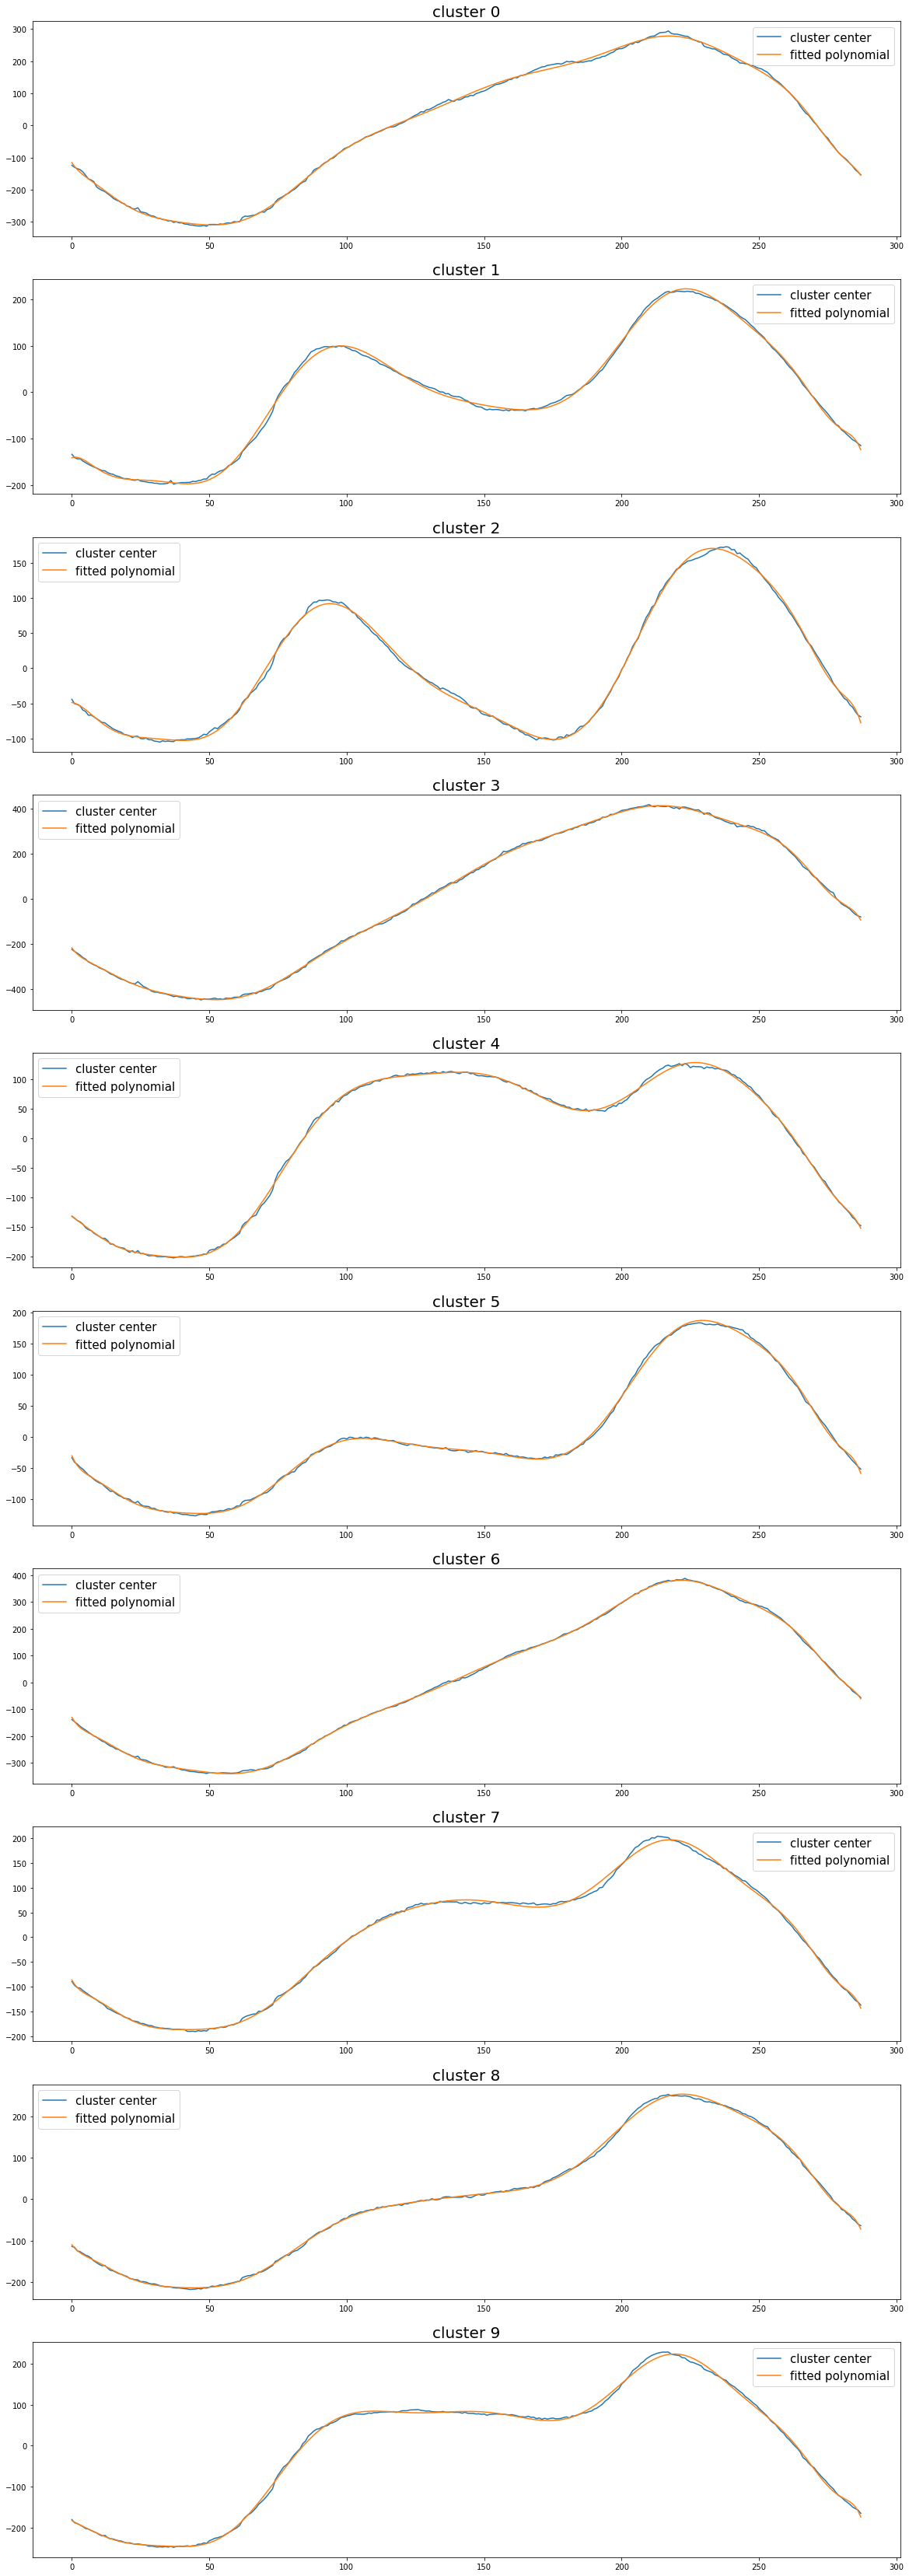

In [225]:
poly_clusters = pd.DataFrame(index=cluster_centers.index)
poly_models = []
x = np.arange(0,1440,5)[:,None]
fig, ax = plt.subplots(nrows=k, figsize=(20,60))
for i in range(k):
    y = cluster_centers[i].to_numpy()
    
    # model
    poly_models.append(Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=15, include_bias=False)),
        ('reg', LinearRegression())
        ]))
    
    poly_models[i].fit(x,y)
    y_pred = poly_models[i].predict(x)
    poly_clusters[i] = y_pred
    ax[i].plot(y, label='cluster center')
    ax[i].plot(y_pred, label='fitted polynomial')
    ax[i].legend(fontsize=15)
    ax[i].set_title('cluster '+str(i),fontsize=20)

<AxesSubplot:xlabel='time'>

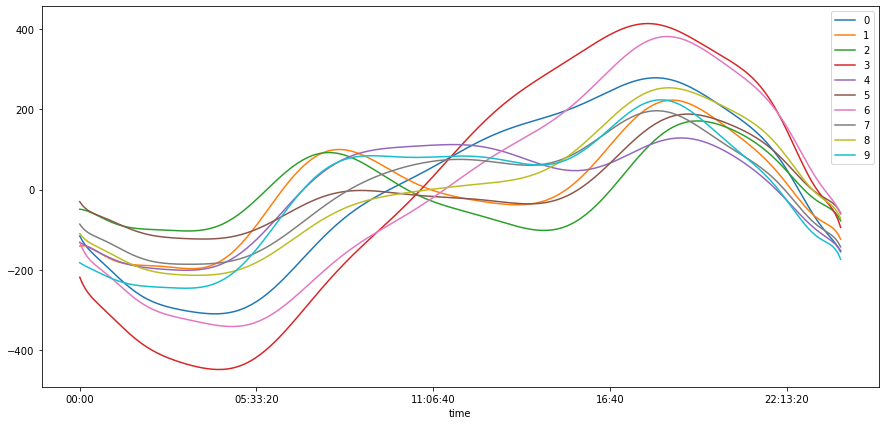

In [226]:
# plot all the polynomial approximations
poly_clusters.plot(figsize=(15,7))

C:\Users\javier.perez-alvaro\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4710.76061587215, tolerance: 280.93043196875004
  model = cd_fast.enet_coordinate_descent(


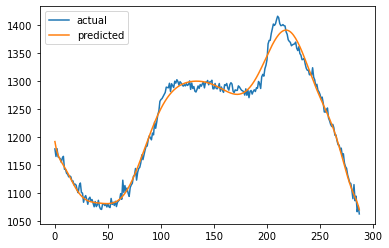

In [227]:
# let as check that we can approximate daily electricity curves as linear combinations of cluster centers

day = 10 # choose a day
load_curve = data_table.iloc[:,day].to_numpy()

# linear regression model with Lasso regularization
from sklearn.linear_model import Lasso
reg = Lasso(max_iter=5000)
reg.fit(poly_clusters,load_curve)
load_curve_pred = reg.predict(poly_clusters)

# plot the curve and the predicted curve
plt.plot(load_curve, label = 'actual')
plt.plot(load_curve_pred, label = 'predicted')
plt.legend()

In [228]:
# Save the dataframe
poly_clusters.to_csv('clusters_CAPITL.csv')

## Putting it all together: forecasting daily electricity curves

In [229]:
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Text(0.5, 1.0, 'electricity curve for 2020-03-16')

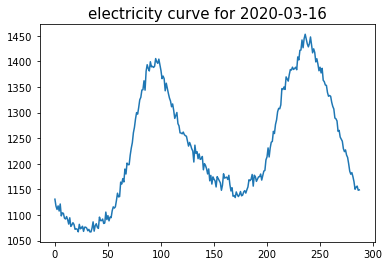

In [300]:
# let as choose a day
day = '2020-03-16'
i = 75 
load_curve = data_table.iloc[:,i].to_numpy()
plt.plot(load_curve)
plt.title('electricity curve for 2020-03-16', fontsize=15)

We'll use the mean-load and shape predictors to obtain a baseline forecast.
This baseline forecast will be the starting point of our forecaster.

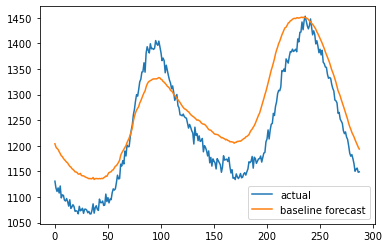

In [395]:
'baseline forecast'

# mean
x = data_load.loc[[day]].drop('load',axis=1)
mean = forest_load_clf.predict(x)

# shape 
x = cluster_data.loc[[day]].drop('cluster',axis=1)
cluster = forest_cluster_clf.predict(x)

# baseline curve
cluster_curve = cluster_small.iloc[:,cluster].to_numpy().flatten()
cluster_curve += mean 

plt.plot(load_curve, label='actual')
plt.plot(cluster_curve, label = 'baseline forecast')
plt.legend()

In [402]:
# Approximate baseline forecast as a cluster combination
gd_reg = SGDRegressor(penalty='l1',alpha=0.0001,max_iter=100, eta0=1e-6, warm_start=True) 
lasso_reg = Lasso(alpha=10)

gd_reg.fit(poly_clusters,cluster_curve)
lasso_reg.fit(poly_clusters,cluster_curve)

gd_reg.coef_ = lasso_reg.coef_
gd_reg.intercept_ = np.array([lasso_reg.intercept_])

cluster_curve_pred = gd_reg.predict(poly_clusters)

As we get data points from the NYISO data stream, our forecast should get better.

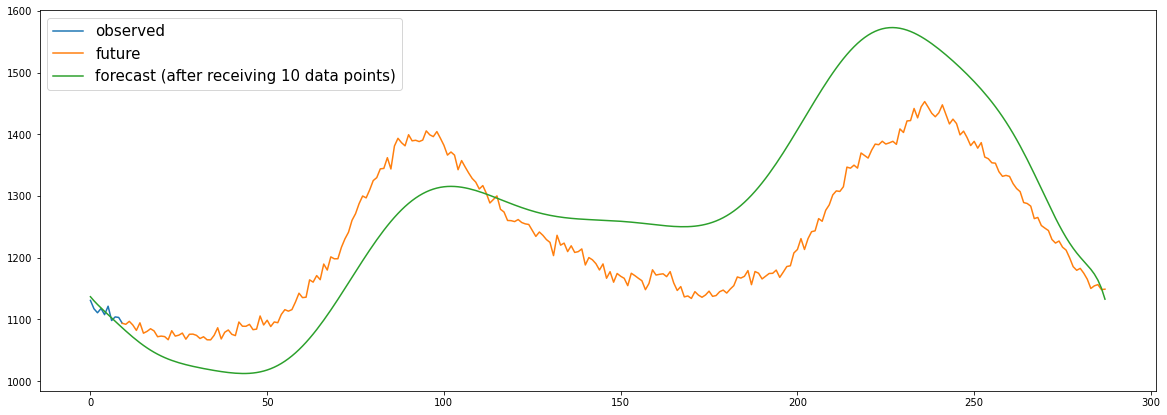

In [403]:
# forecast after receiving 10 data points
plt.figure(figsize=(20,7))
n = 10 
plt.plot(range(n), load_curve[:n], label='observed')
plt.plot(range(n-1,288), load_curve[n-1:], label='future')

# Gradient Descent 
gd_reg.fit(poly_clusters.iloc[:n],load_curve[:n])
load_curve_pred = gd_reg.predict(poly_clusters)

#load_curve_pred = reg.predict(clusters)
plt.plot(load_curve_pred, label = 'forecast (after receiving 10 data points)')
plt.legend(fontsize=15)

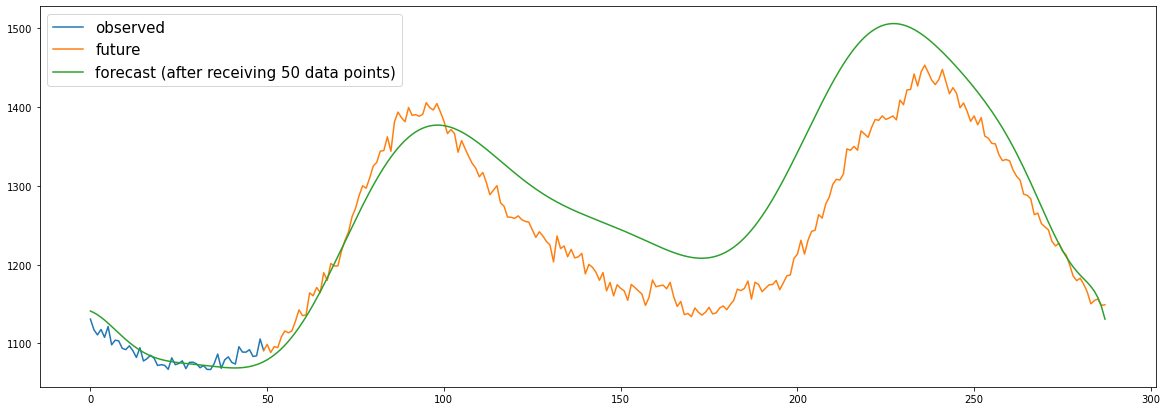

In [404]:
# forecast after receiving 10 data points
plt.figure(figsize=(20,7))
n = 50
plt.plot(range(n), load_curve[:n], label='observed')
plt.plot(range(n-1,288), load_curve[n-1:], label='future')

# Gradient Descent 
gd_reg.fit(poly_clusters.iloc[:n],load_curve[:n])
load_curve_pred = gd_reg.predict(poly_clusters)

#load_curve_pred = reg.predict(clusters)
plt.plot(load_curve_pred, label = 'forecast (after receiving 50 data points)')
plt.legend(fontsize=15)

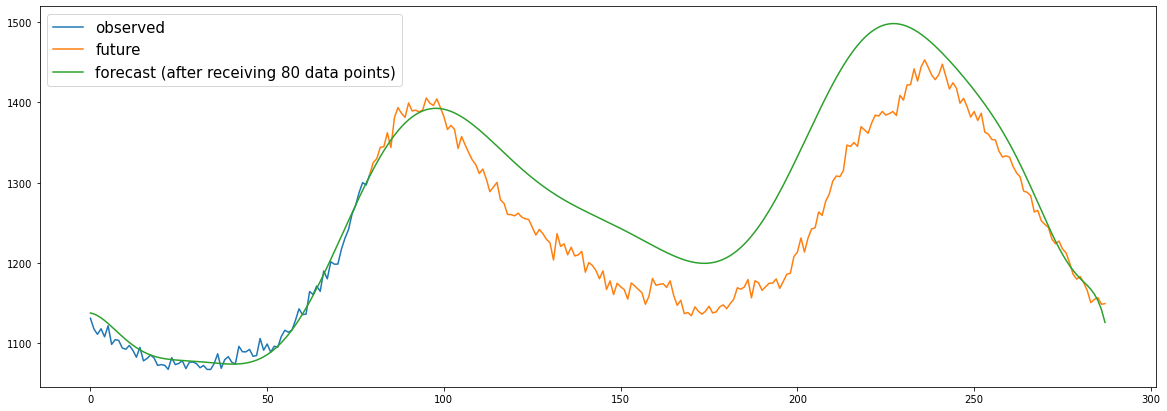

In [405]:
# forecast after receiving 10 data points
plt.figure(figsize=(20,7))
n = 80
plt.plot(range(n), load_curve[:n], label='observed')
plt.plot(range(n-1,288), load_curve[n-1:], label='future')

# Gradient Descent 
gd_reg.fit(poly_clusters.iloc[:n],load_curve[:n])
load_curve_pred = gd_reg.predict(poly_clusters)

#load_curve_pred = reg.predict(clusters)
plt.plot(load_curve_pred, label = 'forecast (after receiving 80 data points)')
plt.legend(fontsize=15)

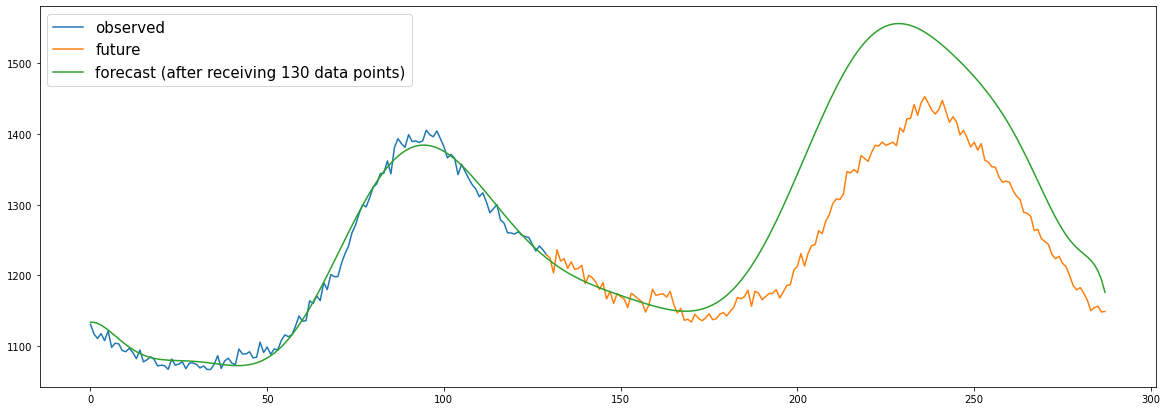

In [408]:
# forecast after receiving 10 data points
plt.figure(figsize=(20,7))
n = 130
plt.plot(range(n), load_curve[:n], label='observed')
plt.plot(range(n-1,288), load_curve[n-1:], label='future')

# Gradient Descent 
gd_reg.fit(poly_clusters.iloc[:n],load_curve[:n])
load_curve_pred = gd_reg.predict(poly_clusters)

#load_curve_pred = reg.predict(clusters)
plt.plot(load_curve_pred, label = 'forecast (after receiving 130 data points)')
plt.legend(fontsize=15)

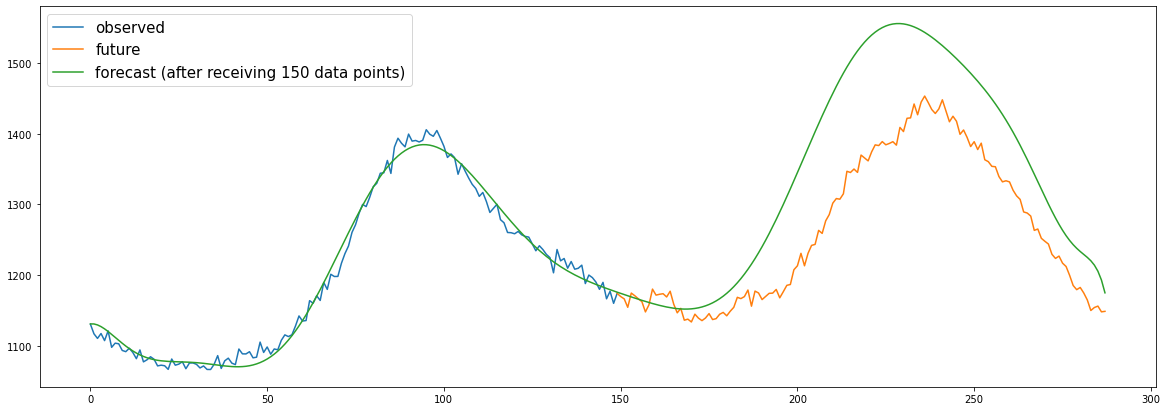

In [409]:
# forecast after receiving 10 data points
plt.figure(figsize=(20,7))
n = 150
plt.plot(range(n), load_curve[:n], label='observed')
plt.plot(range(n-1,288), load_curve[n-1:], label='future')

# Gradient Descent 
gd_reg.fit(poly_clusters.iloc[:n],load_curve[:n])
load_curve_pred = gd_reg.predict(poly_clusters)

#load_curve_pred = reg.predict(clusters)
plt.plot(load_curve_pred, label = 'forecast (after receiving 150 data points)')
plt.legend(fontsize=15)